<a href="https://colab.research.google.com/github/DeeperSense/BTS-2023/blob/master/sonavision/sonavision-bts-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BTS 2023 - Tutorial 4**
## **DeeperSense:** AI Methods for Underwater Visual-Acoustic Perception
### **SONAVision** - Sonar-to-RGB Image translation for Diver Monitoring


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/DeeperSense/BTS-2023/blob/master/sonavision/sonavision-bts-tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/DeeperSense/BTS-2023/blob/master/sonavision/sonavision-bts-tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial a demonstration of **SONAVision** in presented, a deep model for generating RGB/optical images of underwater divers in low visibility conditions.

The model is based on a multi-input [pix2pix](https://arxiv.org/abs/1611.07004) network, a **conditional Generative Adversarial Network** (cGAN) which takes a combination of a sonar image and a low visibility camera image as input, and reconstructs a corresponding camera image with enhanced visibility.




## Image-to-image Translation with cGANs

The pix2pix model proposed by [Isola et al. (2017)](https://arxiv.org/abs/1611.07004), is a conditiona GAN which as the name implies, the generated output image is *conditioned* on an imput image.

This method was applied to a range of tasks, such as synthesizing photos from label maps, turning black and white images into colorized photos, generating aerial images from Google Maps photos, and even transforming sketches into photos.

An example is given below using the facades dataset where pix2pix was used to generate an image of a building facade using a semantic map image as condition or input
![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)

## Multi-input cGAN
The idea here is to condition the GAN on a pair of a sonar image and a distorted camera image, in order to reconstruct a good visibility camera image


## Imports
You will need to import the following
- numpy
- tensorflow for using the trained model
- opencv for image manipulation
- matplotlib for plotting

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Downloading the assets
Using the following link, you can download the trained model files and test images

In [2]:
!curl https://cloud.dfki.de/owncloud/index.php/s/jyTsJfSR6fCjMoR/download --output data.zip
!unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1064M    0 1064M    0     0  17.5M      0 --:--:--  0:01:00 --:--:-- 18.6M
Archive:  data.zip
   creating: BTS23/
   creating: BTS23/indoor-pool/
   creating: BTS23/indoor-pool/models/
   creating: BTS23/indoor-pool/models/assets/
 extracting: BTS23/indoor-pool/models/saved_model.pb  
   creating: BTS23/indoor-pool/models/variables/
 extracting: BTS23/indoor-pool/models/variables/variables.data-00000-of-00001  
 extracting: BTS23/indoor-pool/models/variables/variables.index  
   creating: BTS23/indoor-pool/test-data/
 extracting: BTS23/indoor-pool/test-data/0.png  
 extracting: BTS23/indoor-pool/test-data/1.png  
 extracting: BTS23/indoor-pool/test-data/2.png  
   creating: BTS23/lake-cropped/
   creating: BTS23/lake-cropped/models/
   creating: BTS23/lake-cropped/models/assets/
 extracting: BTS23/lake-cropped/models/keras_met

### Select a Dataset and load the corresponding model

In [6]:
dataset = "lake-cropped" #@param ["indoor-pool", "lake-cropped"]
model_dir = "/content/BTS23/{}/models".format(dataset)
generator = tf.keras.models.load_model(model_dir)
generator.compile()

You can also visualize the model using the following command

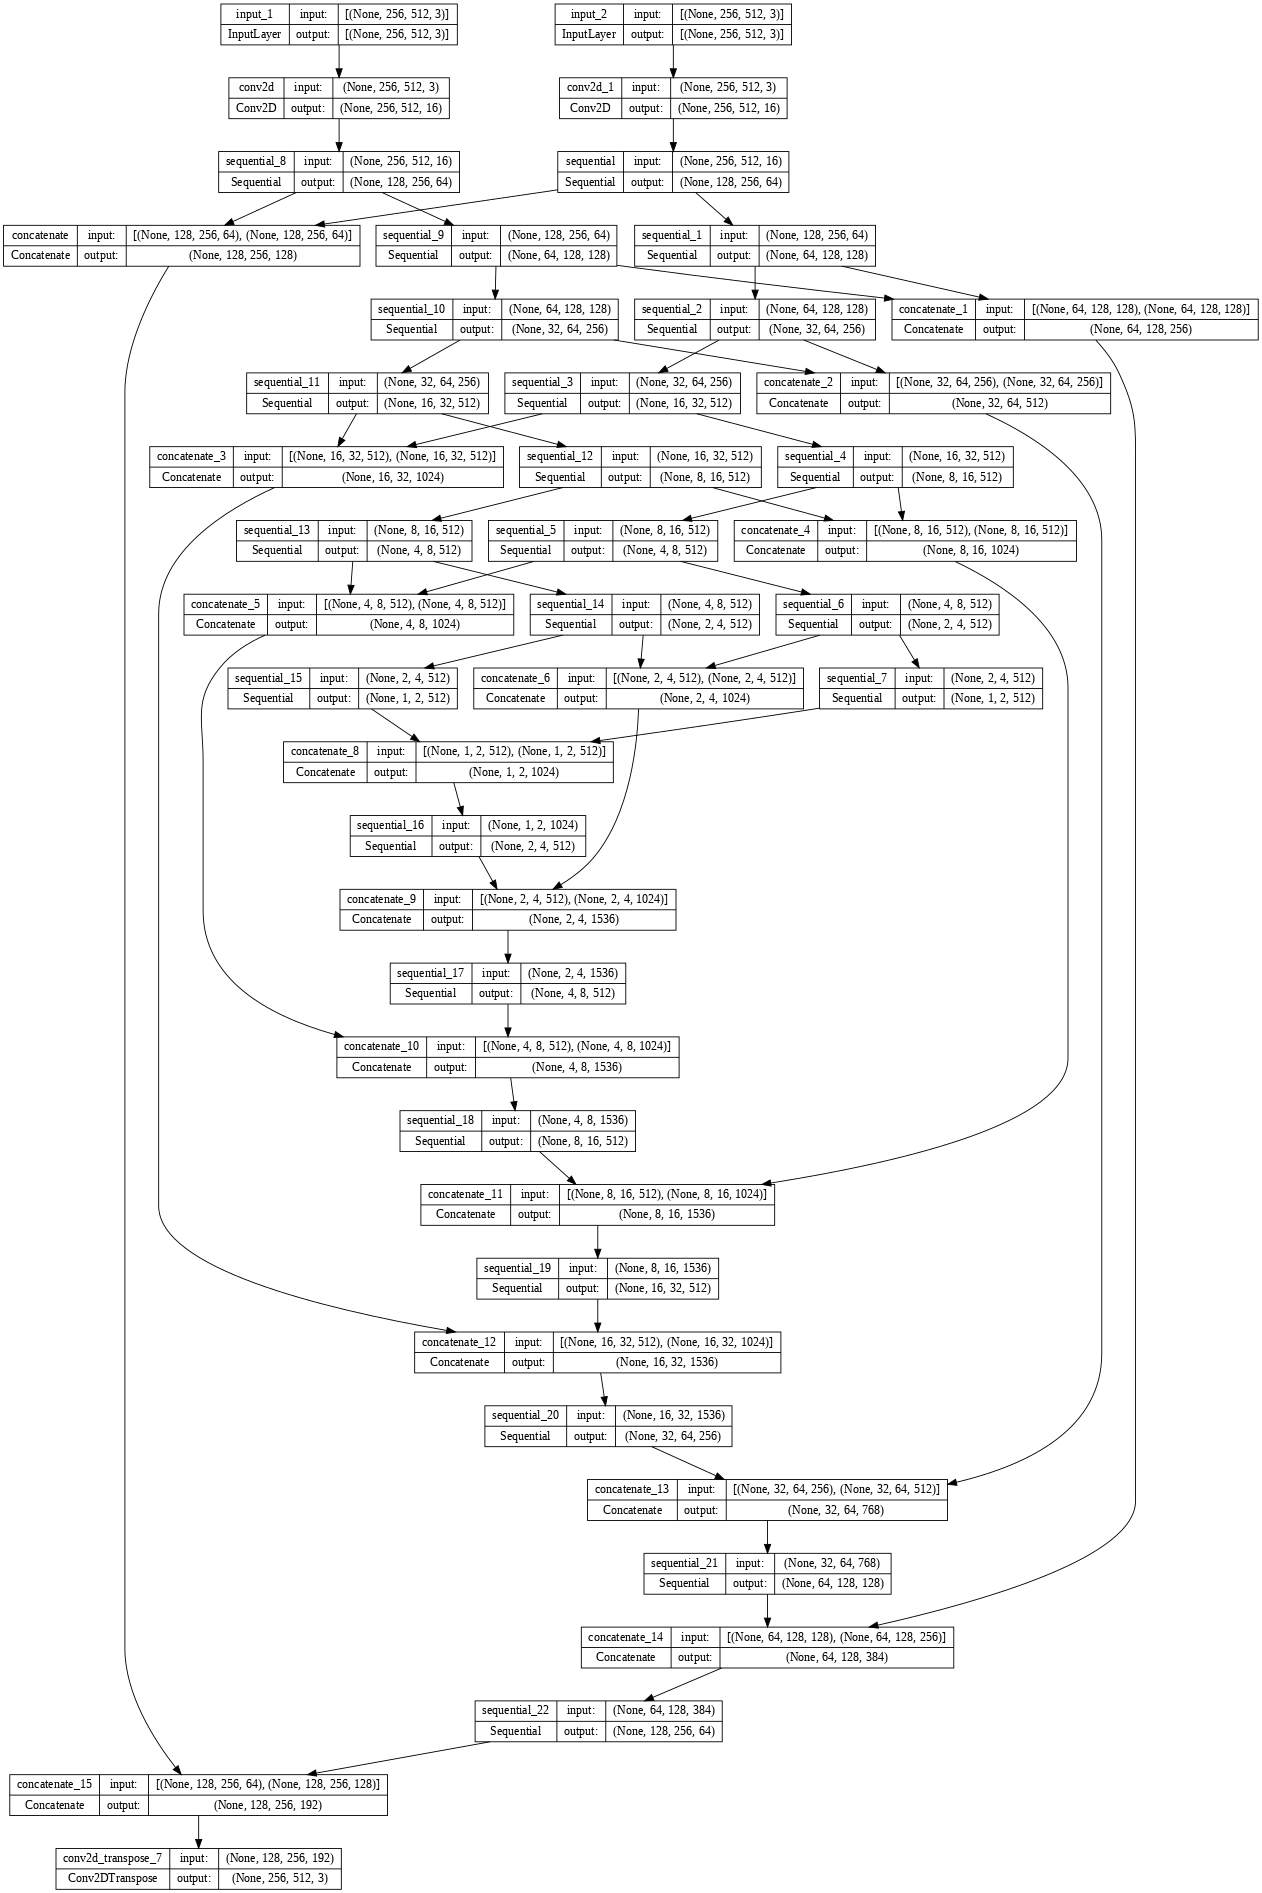

In [5]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Data selection and visualization

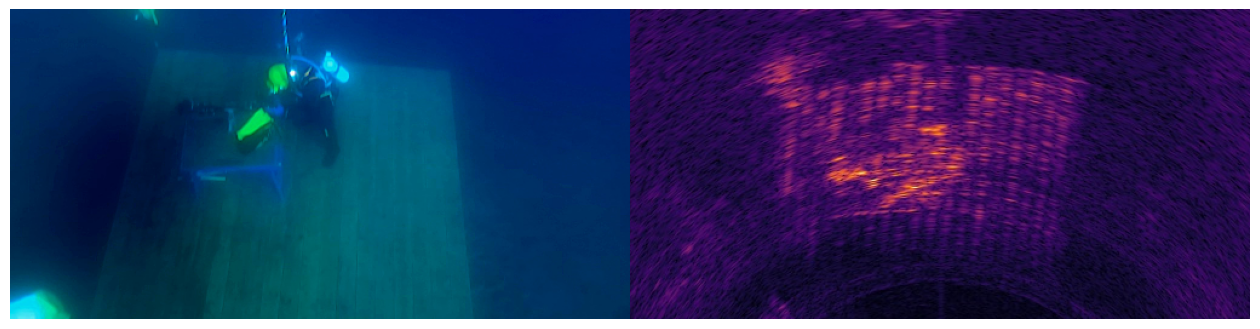

In [12]:
image_file = "/content/BTS23/{}/test-data/1.png".format(dataset)
image = tf.io.read_file(image_file)
image = tf.io.decode_png(image)

plt.figure(figsize=(16,5))
plt.imshow(image)
plt.axis('off')

# image width
w = tf.shape(image)[1] // 2

# split camera and sonar, and cast into tf tensors
camera = tf.cast(image[:, :w, :], tf.float32)
sonar = tf.cast(image[:, w:, :], tf.float32)

## Few utility functions

In [14]:
def normalize_inputs(x):
  """ Normalize a list of 8-bit images to the range of [-1,1]
  """
  normalized = []
  for img in x:
    normalized.append((img / 127.5) - 1)
  return normalized

def darken(image, d: int = 0.5):
  dark = (1-d)*image
  return dark

def blur(image, d: int = 0.5):
  var = 10 * d # variance
  k = int(np.ceil(100 * d) // 2 * 2 + 1)
  kernel = (k,k) # kernel
  blurred = cv2.GaussianBlur(src=image.numpy(), ksize=kernel, sigmaX=var, sigmaY=var) # gaussian blur
  return blurred

### Image degradation

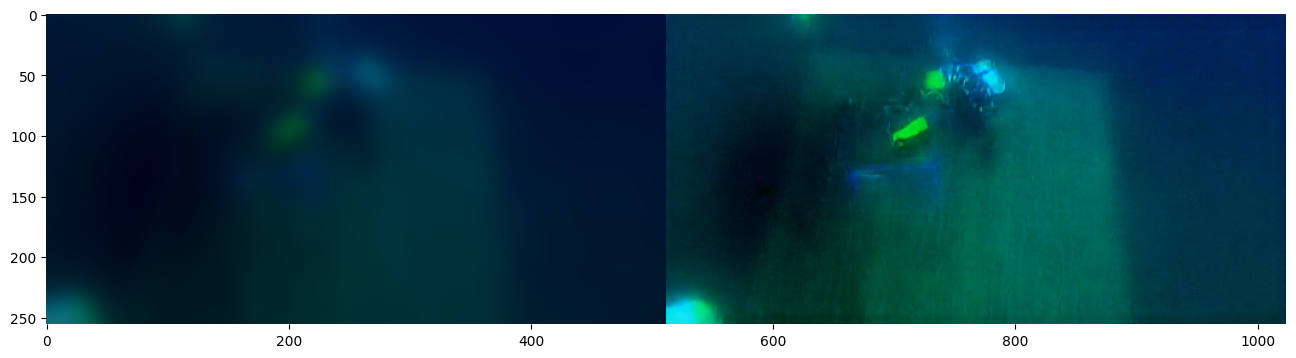

In [15]:
d = 0.5 # darkness factor
dark = darken(camera, d)
dark = blur(dark,0.75)

dark, sonar = normalize_inputs([dark, sonar])

prediction = generator([dark[None,:,:,:], sonar[None,:,:,:]], training=True)
pred = prediction[0].numpy()

stacked = np.hstack((dark,pred))
stacked = stacked*0.5+0.5
plt.figure(figsize=(16,5))
plt.imshow(stacked)

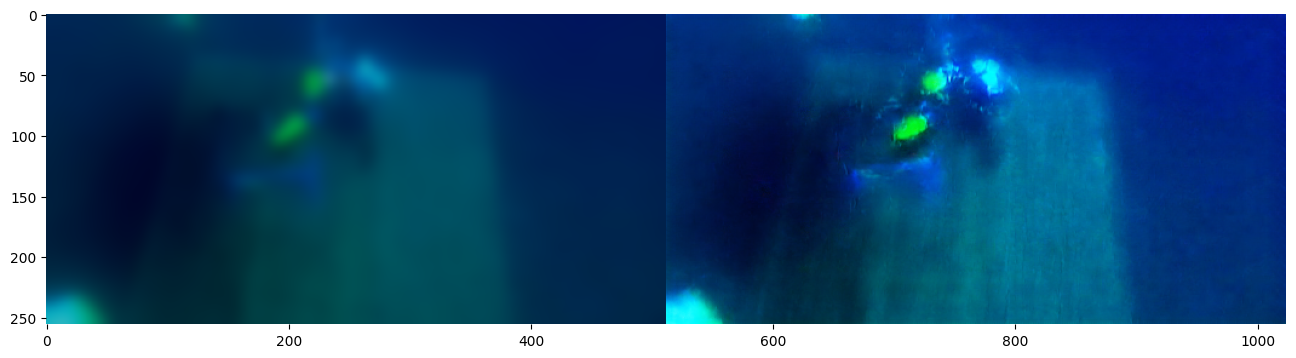

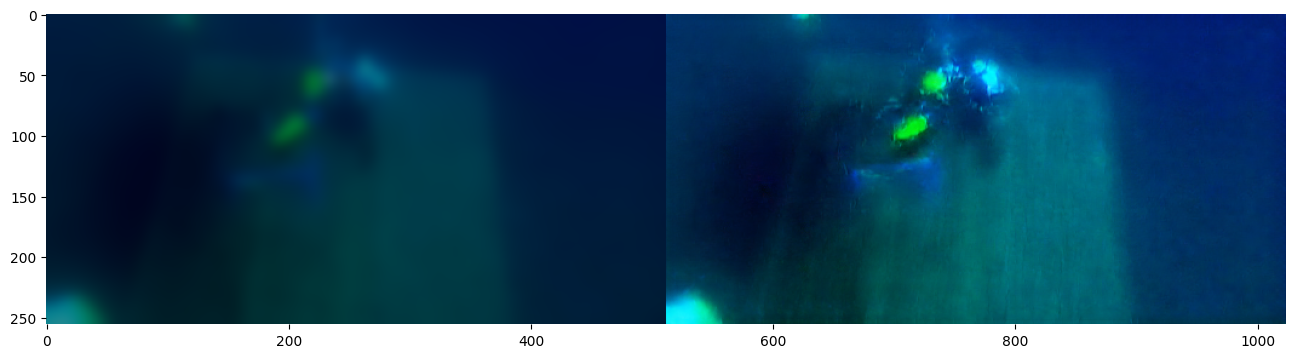

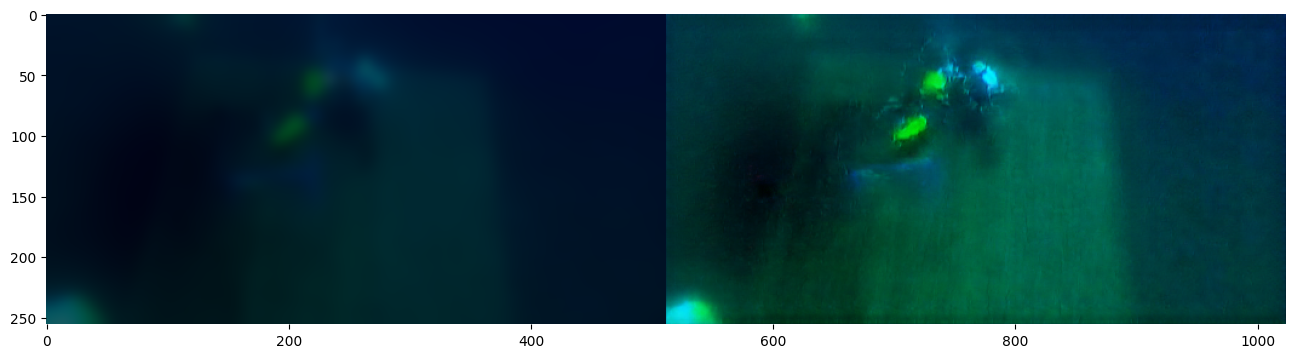

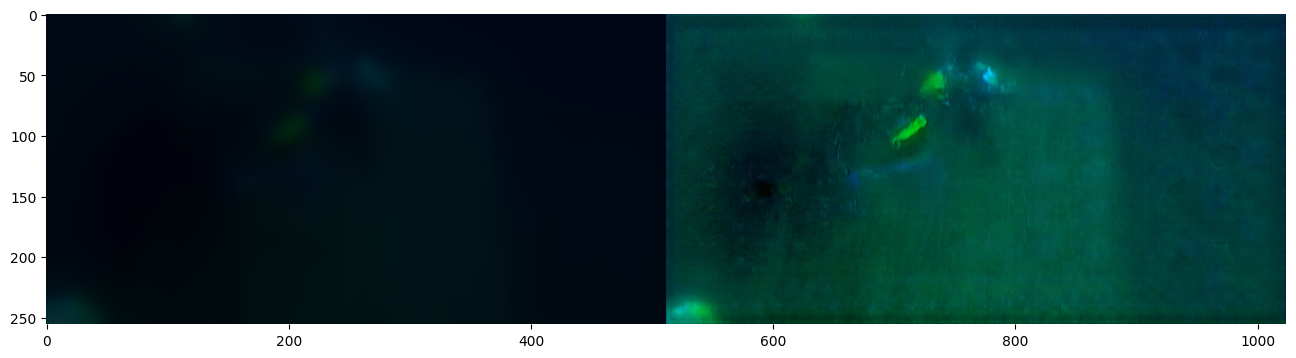

In [16]:
for d in np.arange(0.2,1,0.2):
  dark = darken(camera, d)
  dark = blur(dark)
  dark, sonar = normalize_inputs([dark, sonar])
  prediction = generator([dark[None,:,:,:], sonar[None,:,:,:]], training=True)
  pred = prediction[0].numpy()
  stacked = np.hstack((dark,pred))
  stacked = stacked*0.5+0.5
  plt.figure(figsize=(16,5))
  plt.imshow(stacked)